# Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE
!pip install opentsne
from openTSNE import TSNE

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Make Game Dataset

In [3]:
class GamesDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.data = self.data.drop(columns=["Name", "BGGId"], errors='ignore')
        # another check to select only numerical columns 
        self.features = self.data.select_dtypes(include=[np.number]).values.astype(np.float32)
        self.transform = transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        sample = self.features[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

In [4]:
csv_file = "../../bgg_data/overall_games.csv"
df = pd.read_csv(csv_file)
df = df.dropna()
split_idx = int(len(df) * .7)
train = df[:split_idx]
test = df[split_idx:]
batch_size = 32
trainset = GamesDataset(train)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = GamesDataset(test)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

# Make Autoencoder

In [5]:
class Autoencoder_v1(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(Autoencoder_v1, self).__init__()
        # encoder compresses input to latent_dim in bottleneck layer
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # decoder reconstructs the input from embeddings in the bottleneck layer
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    
class Autoencoder_v2(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(Autoencoder_v2, self).__init__()
        # Encoder with more layers and intermediate dimensionality reduction
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        # Decoder mirroring the encoder structure
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=64, binary_start_idx=514):
        super(Autoencoder, self).__init__()
        self.binary_start_idx = binary_start_idx
        self.continuous_dim = binary_start_idx
        self.binary_dim = input_dim - binary_start_idx

        # shared encoder for all features
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim)
        )
        # decoder branch for continuous features (no activation in the final layer)
        self.decoder_cont = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.continuous_dim)
        )
        # decoder branch for binary features (apply sigmoid to get probabilities)
        self.decoder_bin = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.binary_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        cont_recon = self.decoder_cont(latent)
        bin_recon = self.decoder_bin(latent)
        # concat the continuous and binary reconstructions
        reconstructed = torch.cat([cont_recon, bin_recon], dim=1)
        return reconstructed, latent

# Define Training Procedure, Loss Function, and Hyperparamters

In [6]:
def evaluate_autoencoder(model, dataloader, criterion, device='cpu', binary_start_idx=0):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            reconstructed, latent = model(batch)
            loss = criterion(reconstructed, batch, binary_start_idx)
            total_loss += loss.item() * batch.size(0)
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

def train_autoencoder(model, train_loader, test_loader, criterion, optimizer, num_epochs=20, device='cpu', binary_start_idx=0):
    model.to(device)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            reconstructed, latent = model(batch)
            loss = criterion(reconstructed, batch, binary_start_idx)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * batch.size(0)
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        avg_test_loss = evaluate_autoencoder(model, test_loader, criterion, device, binary_start_idx)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return model, train_losses, test_losses

In [7]:
def plot_losses(train_losses, test_losses, title="Training and Test Loss Over Epochs"):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
def composite_loss(reconstructed, target, binary_start_idx, bce_weight=1.0):
    # MSE for continuous features
    mse_loss = F.mse_loss(reconstructed[:, :binary_start_idx], target[:, :binary_start_idx])
    
    # BCE for binary flags
    # Use BCEWithLogitsLoss if your model's decoder outputs raw scores (logits)
    #bce_loss = F.binary_cross_entropy_with_logits(reconstructed[:, binary_start_idx:], target[:, binary_start_idx:])
    bce_loss = F.binary_cross_entropy(reconstructed[:, binary_start_idx:], target[:, binary_start_idx:])

    # Weighted sum of losses
    total_loss = mse_loss + bce_weight * bce_loss
    return total_loss

In [12]:
epochs = 50
learning_rate = .00005
input_dim = trainset.features.shape[1]
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
latent_dim = 64
binary_start_idx = 514
criterion = composite_loss

# Train and Evaluate the Autoencoder

In [13]:
model, train_loss, text_loss = train_autoencoder(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    num_epochs=epochs, 
    device=device, 
    binary_start_idx=binary_start_idx)

Epoch 1/50, Train Loss: 0.1756, Test Loss: 0.0568
Epoch 2/50, Train Loss: 0.0308, Test Loss: 0.0416
Epoch 3/50, Train Loss: 0.0279, Test Loss: 0.0383
Epoch 4/50, Train Loss: 0.0269, Test Loss: 0.0371
Epoch 5/50, Train Loss: 0.0264, Test Loss: 0.0349
Epoch 6/50, Train Loss: 0.0259, Test Loss: 0.0337
Epoch 7/50, Train Loss: 0.0254, Test Loss: 0.0326
Epoch 8/50, Train Loss: 0.0272, Test Loss: 0.0317
Epoch 9/50, Train Loss: 0.0246, Test Loss: 0.0302
Epoch 10/50, Train Loss: 0.0241, Test Loss: 0.0293
Epoch 11/50, Train Loss: 0.0238, Test Loss: 0.0285
Epoch 12/50, Train Loss: 0.0233, Test Loss: 0.0276
Epoch 13/50, Train Loss: 0.0229, Test Loss: 0.0267
Epoch 14/50, Train Loss: 0.0225, Test Loss: 0.0261
Epoch 15/50, Train Loss: 0.0246, Test Loss: 0.0253
Epoch 16/50, Train Loss: 0.0218, Test Loss: 0.0247
Epoch 17/50, Train Loss: 0.0214, Test Loss: 0.0240
Epoch 18/50, Train Loss: 0.0210, Test Loss: 0.0237
Epoch 19/50, Train Loss: 0.0207, Test Loss: 0.0232
Epoch 20/50, Train Loss: 0.0203, Test Lo

In [14]:
torch.save(model, 'autoencoder_v3.pth')

In [15]:
#model = torch.load('autoencoder.pth')

### Loss Curve

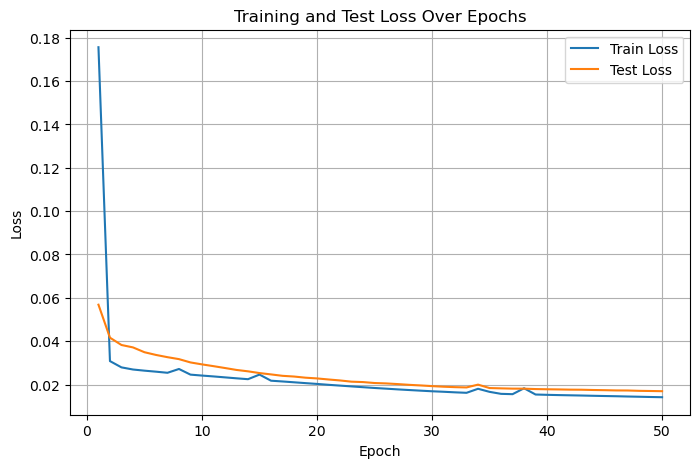

In [16]:
plot_losses(train_loss, text_loss)

### Reconstructed Error Analysis

In [17]:
def compute_reconstruction_errors(model, dataloader, criterion, binary_start_idx, device='cpu'):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            reconstructed, _ = model(batch)
            # Compute per-sample mean squared error over all features
            error = criterion(reconstructed, batch, binary_start_idx)
            print
            errors.append(error.item()) # * batch.size(0))
    return np.array(errors)

def plot_error_distribution(model, dataloader, criterion, binary_start_idx, device='cpu'):
    test_errors = compute_reconstruction_errors(model, test_loader, criterion, binary_start_idx, device=device)
    plt.figure(figsize=(10, 5))
    plt.hist(test_errors, bins=50, alpha=0.7)
    plt.xlabel('Reconstruction Error (Composite MSE & BCE)')
    plt.ylabel('Frequency')
    plt.title('Histogram of Reconstruction Errors on Test Set')
    plt.show()

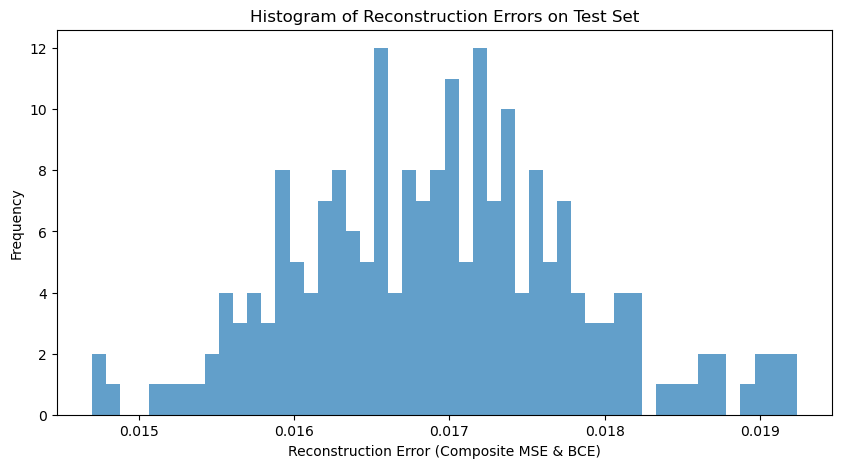

In [18]:
plot_error_distribution(model, test_loader, criterion, binary_start_idx, device=device)

### Visualize Embedding Space
Run tsne for dimensionality reduction and then visualize colored by a few input features to determine separation and if the autoencoder is capturing meaningful information about the games.

In [19]:
def get_embeddings(model, dataloader, device='cpu'):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            _, latent = model(batch)
            embeddings.append(latent.cpu().numpy())
    return np.vstack(embeddings)
 
def plot_tsne(embeddings, color_by=None, sample_size=1500, dataset=None):
    # Downsample embeddings if necessary
    num_samples = embeddings.shape[0]
    if num_samples > sample_size:
        indices = np.random.choice(num_samples, sample_size, replace=False)
        embeddings = embeddings[indices]
        if color_by is not None:
            # If color_by is a string, retrieve the values from dataset.data using the same indices.
            if isinstance(color_by, str):
                if dataset is None:
                    raise ValueError("When using a column name for color_by, you must provide the dataset argument.")
                color_values = dataset.data[color_by].values[indices]
            else:
                # If color_by is an array-like, downsample it with the same indices.
                color_values = np.array(color_by)[indices]
    else:
        if color_by is not None:
            if isinstance(color_by, str):
                if dataset is None:
                    raise ValueError("When using a column name for color_by, you must provide the dataset argument.")
                color_values = dataset.data[color_by].values
            else:
                color_values = np.array(color_by)
    tsne = TSNE(
        perplexity=30,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=False,
    )
    embeddings_2d = tsne.fit(embeddings)

    plt.figure(figsize=(8, 6))
    if color_by is not None:
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=color_values, cmap='viridis', alpha=0.7)
        plt.colorbar(scatter, label=color_by if isinstance(color_by, str) else "color")
    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
    plt.title('t-SNE Visualization of the Latent Space')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()
    

In [20]:
embeddings = get_embeddings(model, test_loader, device=device)

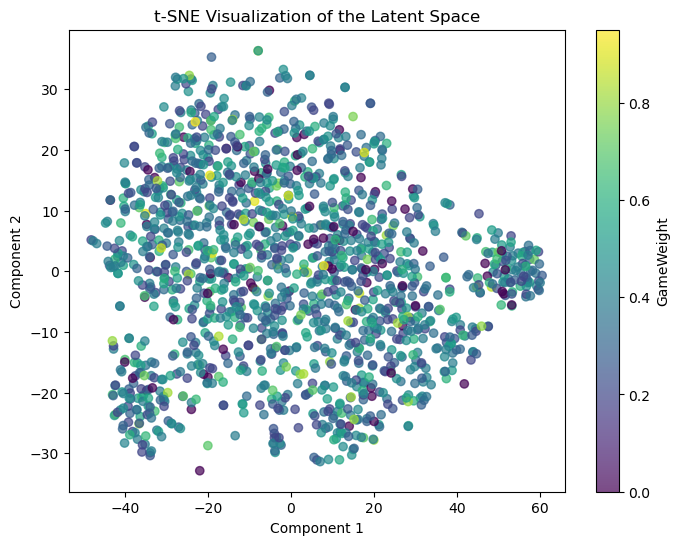

In [21]:
plot_tsne(embeddings, color_by="GameWeight", dataset=testset)

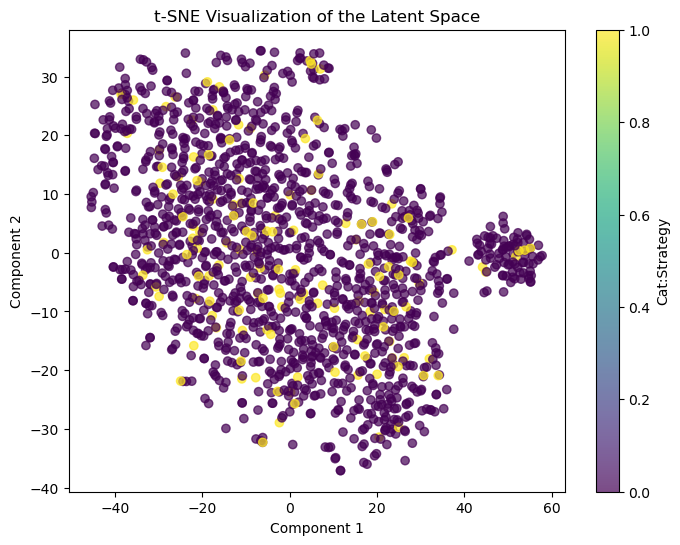

In [22]:
plot_tsne(embeddings, color_by="Cat:Strategy", dataset=testset)

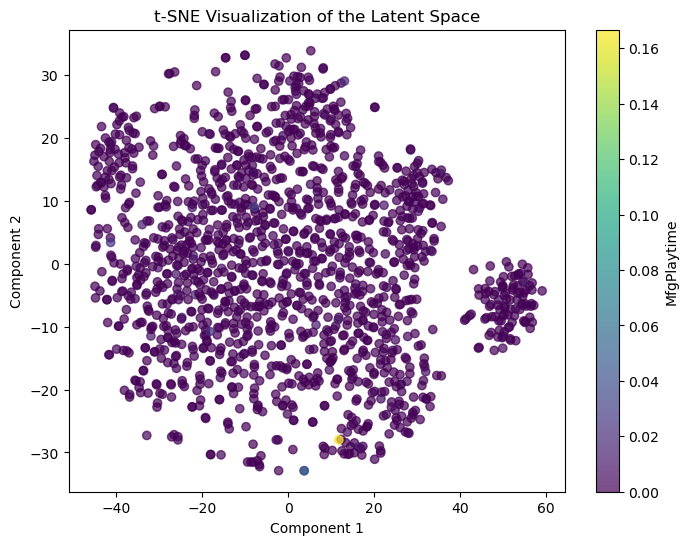

In [23]:
plot_tsne(embeddings, color_by="MfgPlaytime", dataset=testset)

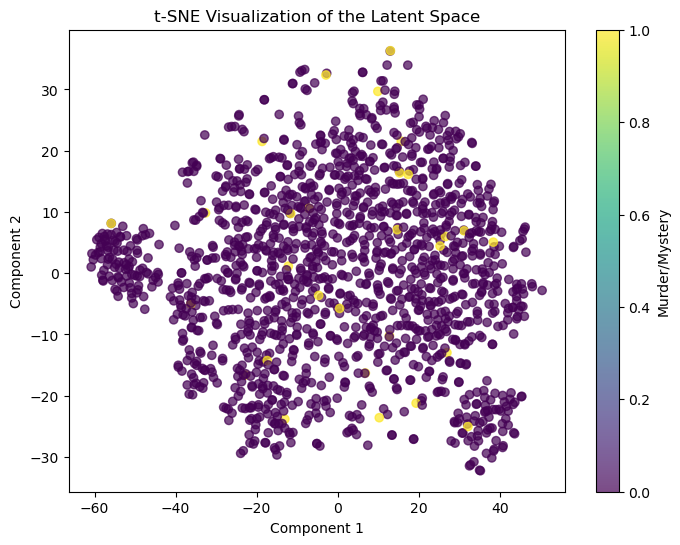

In [24]:
plot_tsne(embeddings, color_by="Murder/Mystery", dataset=testset)

### Compare Original and Reconstructed Data

In [25]:
def compute_stats(model, dataloader, device='cpu', binary_start_idx=0):
    model.eval()
    originals = []
    reconstructions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            reconstructed, _ = model(batch)
            originals.append(batch.cpu().numpy())
            reconstructions.append(reconstructed.cpu().numpy())
    originals = np.vstack(originals)
    reconstructions = np.vstack(reconstructions)
    
    stats = {}
    # Continuous features: columns 0 to binary_start_idx
    stats['continuous_original_mean'] = originals[:, :binary_start_idx].mean(axis=0)
    stats['continuous_recon_mean'] = reconstructions[:, :binary_start_idx].mean(axis=0)
    stats['continuous_original_std'] = originals[:, :binary_start_idx].std(axis=0)
    stats['continuous_recon_std'] = reconstructions[:, :binary_start_idx].std(axis=0)
    
    # Binary features: columns binary_start_idx to end
    stats['binary_original_mean'] = originals[:, binary_start_idx:].mean(axis=0)
    stats['binary_recon_mean'] = reconstructions[:, binary_start_idx:].mean(axis=0)
    stats['binary_original_std'] = originals[:, binary_start_idx:].std(axis=0)
    stats['binary_recon_std'] = reconstructions[:, binary_start_idx:].std(axis=0)
    
    return stats, originals, reconstructions

In [26]:
stats, originals, reconstructions = compute_stats(model, test_loader, device=device, binary_start_idx=binary_start_idx)

print("Continuous Original Mean (first 10 values):", stats['continuous_original_mean'][:10])
print("Continuous Reconstruction Mean (first 10 values):", stats['continuous_recon_mean'][:10])
print("Binary Original Mean (first 10 values):", stats['binary_original_mean'][:10])
print("Binary Reconstruction Mean (first 10 values):", stats['binary_recon_mean'][:10])

Continuous Original Mean (first 10 values): [0.48656723 0.4557176  0.48575687 0.5190291  0.4553291  0.534358
 0.53109425 0.47877377 0.48943195 0.50592923]
Continuous Reconstruction Mean (first 10 values): [0.47885486 0.46612972 0.47793016 0.50676644 0.4585095  0.5133835
 0.52144015 0.451621   0.4605239  0.48733887]
Binary Original Mean (first 10 values): [0.06294663 0.07693477 0.00319295 0.01353201 0.01900563 0.00562567
 0.00243272 0.0989813  0.03922761 0.277026  ]
Binary Reconstruction Mean (first 10 values): [0.06367381 0.07810958 0.00954869 0.01601855 0.02983011 0.01159358
 0.00117955 0.07558683 0.03740846 0.28584707]


In [21]:
print(df.columns.tolist())

['desc_emb_0', 'desc_emb_1', 'desc_emb_2', 'desc_emb_3', 'desc_emb_4', 'desc_emb_5', 'desc_emb_6', 'desc_emb_7', 'desc_emb_8', 'desc_emb_9', 'desc_emb_10', 'desc_emb_11', 'desc_emb_12', 'desc_emb_13', 'desc_emb_14', 'desc_emb_15', 'desc_emb_16', 'desc_emb_17', 'desc_emb_18', 'desc_emb_19', 'desc_emb_20', 'desc_emb_21', 'desc_emb_22', 'desc_emb_23', 'desc_emb_24', 'desc_emb_25', 'desc_emb_26', 'desc_emb_27', 'desc_emb_28', 'desc_emb_29', 'desc_emb_30', 'desc_emb_31', 'desc_emb_32', 'desc_emb_33', 'desc_emb_34', 'desc_emb_35', 'desc_emb_36', 'desc_emb_37', 'desc_emb_38', 'desc_emb_39', 'desc_emb_40', 'desc_emb_41', 'desc_emb_42', 'desc_emb_43', 'desc_emb_44', 'desc_emb_45', 'desc_emb_46', 'desc_emb_47', 'desc_emb_48', 'desc_emb_49', 'desc_emb_50', 'desc_emb_51', 'desc_emb_52', 'desc_emb_53', 'desc_emb_54', 'desc_emb_55', 'desc_emb_56', 'desc_emb_57', 'desc_emb_58', 'desc_emb_59', 'desc_emb_60', 'desc_emb_61', 'desc_emb_62', 'desc_emb_63', 'desc_emb_64', 'desc_emb_65', 'desc_emb_66', 'des

In [33]:
input_dim

4363